In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
%cd /content/drive/MyDrive/masters/Advanced_AI

/content/drive/MyDrive/masters/Advanced_AI


In [60]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [61]:
# imports
import nltk
import numpy as np
np.random.seed(0)
import pandas as pd
import tensorflow as tf
import os
from collections import Counter
import json
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import gensim
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Embedding
from keras.layers import LSTM, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from imblearn.combine import SMOTETomek


In [62]:
class Pipeline:

    def __init__(self, load_setting, n_classes):
        self.load_setting = load_setting
        self.n_classes = n_classes
        pass

    # label names getter
    def get_label_names(self):
        try: return self.enc.inverse_transform(list(range(self.n_classes)))
        except AttributeError:
            print("There is no attribute enc in Preprocessor. encoder is not used in binary classification")

    # loading and preprocessing data.
    def pipe(self):
        data = self.read_data()
        tweets, labels = self.transform_data(data)
        tweets = self.preprocessing(tweets)
        return tweets, labels

    def preprocessing(self, tw):
        tw = [nltk.re.sub(r"http\S+", "link", text) for text in tw]  # replacing links: <LINK>
        tw = [nltk.re.sub(r"@\S+", "tag", text) for text in tw]  # replacing tags: <TAG>
        tw = [nltk.re.sub(r'[0-9]+', " digits ", text) for text in tw]  # replacing tags: digit
        tw = [nltk.re.sub(r"[\'|\"]", " ", text) for text in tw]  # removing ' and "
        tw = [nltk.re.sub(r"\b\w\b", "", text) for text in tw]  # remove single character words
        text_to_list = tf.keras.preprocessing.text.text_to_word_sequence
        tw = [text_to_list(sentence) for sentence in tw]
        stopwords = set(nltk.corpus.stopwords.words('english'))
        tw = [[word for word in words if word not in stopwords] for words in tw]
        tw = [" ".join(tweet) for tweet in tw]
        return np.asarray(tw)

    # if called only for test: train_data is None --> so it returns None xtrain var.
    def tokens(self, test_data, train_data=None, tokenizer=None, maxim=None):
        xtrain = None
        self.maxim = maxim
        if train_data is not None:
            tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
            tokenizer.fit_on_texts(train_data)
            train_indexes = tokenizer.texts_to_sequences(train_data)
            if self.maxim is None:
                self.maxim = max([len(i) for i in train_indexes])
            xtrain = tf.keras.preprocessing.sequence.pad_sequences(train_indexes, maxlen=self.maxim)
        test_indexes = tokenizer.texts_to_sequences(test_data)
        xtest = tf.keras.preprocessing.sequence.pad_sequences(test_indexes, maxlen=self.maxim)
        return tokenizer, xtrain, xtest

    def balance(self, tweets, labels, strategy="under"):
        enc = sklearn.preprocessing.OneHotEncoder()
        vec = sklearn.feature_extraction.text.CountVectorizer()
        # tweets = tweets.reshape((-1,1))
        tweets_enc = vec.fit_transform(tweets)
        tweets_enc = tweets_enc.toarray()
        labels = np.argmax(labels, axis=1)
        if strategy == "under":
            undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='majority')
            y_res, x_res = undersample.fit_resample(tweets_enc, labels)
        elif strategy == "over":
            oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
            y_res, x_res = oversample.fit_resample(tweets_enc, labels)
        else:
            mix = imblearn.combine.SMOTEENN(random_state=0)
            y_res, x_res = mix.fit_resample(tweets_enc, labels)
        x_res = vec.inverse_transform(x_res)
        # x_res = x_res.flatten()
        y_res = enc.fit_transform(y_res)
        return x_res, y_res

    def balancing(self, tweets, labels, strategy="under"):
        
        labels = np.argmax(labels, axis=1)
        if strategy == "under":
            tweets = tweets.reshape((-1, 1))
            undersample = RandomUnderSampler(sampling_strategy='majority')
            tweets, labels = undersample.fit_resample(tweets, labels)
            tweets = tweets.reshape((-1,))
        elif strategy == "over":
            tweets = tweets.reshape((-1, 1))
            oversample = RandomOverSampler(sampling_strategy='minority')
            tweets, labels = oversample.fit_resample(tweets, labels)
            tweets = tweets.reshape((-1,))

        else:
            mix = imblearn.combine.SMOTETomek(random_state=0)
            tweets,labels = mix.fit_resample(tweets,labels)
        labels = tf.keras.utils.to_categorical(labels, num_classes=len(Counter(labels)), dtype='float32')
        return tweets, labels

    def splitting(self, tweets, labels):
        split = sklearn.model_selection.StratifiedShuffleSplit(n_splits=1,
                                                                   test_size=0.1,
                                                                   random_state=20)
        train_idx, test_idx = list(split.split(tweets, labels))[0]
        xtrain = tweets[train_idx]
        ytrain = labels[train_idx]
        xtest = tweets[test_idx]
        ytest = labels[test_idx]
        return xtrain, ytrain, xtest, ytest

    def transform_data(self, data):
        tweets = data.iloc[:, 1].to_numpy()  # tweets to nd array
        if self.load_setting == "relatedness":
            labels = data.iloc[:, 4].to_numpy()  # informativeness is the label column.
        elif self.load_setting == "info_source":
            labels = data.iloc[:,2]
        elif self.load_setting == "info_type":
            labels = data.iloc[:,3]

        if self.load_setting != "relatedness":
            self.enc = LabelEncoder()
            labels = self.enc.fit_transform(labels)
        else:
            # convert label values: not related --> 0 , related --> 1
            for i, label in enumerate(labels):
                if label == "Not applicable":
                    labels[i] = 0
                elif label == "Not related":
                    labels[i] = 0
                else:
                    labels[i] = 1
        labels = tf.keras.utils.to_categorical(labels, num_classes=len(Counter(labels)), dtype='float32')
        return tweets, labels

    def read_data(self):
        try:
            data = pd.read_csv("data/data.csv")
        except FileNotFoundError:
            print("there is no dataset in ")
            list_subfolders = sorted([f.name for f in os.scandir("data") if
                                      f.is_dir()])  # scans the folder "data" to get a list of all subfolders
            # data is the dataframe for all concatenated datasets , initialized with the first crisis data
            data = pd.read_csv("data/" + list_subfolders[0] + "/" + list_subfolders[0] + "-tweets_labeled.csv")
            for i, crisis in enumerate(list_subfolders):
                if i == 0: continue
                crisis_data = pd.read_csv(
                    "data/" + list_subfolders[i] + "/" + list_subfolders[i] + "-tweets_labeled.csv")
                data = pd.concat([data, crisis_data], sort=False, ignore_index=True)
        return data

In [63]:
# configurations
# ~~~~~setting up the parameters of the model~~~~~~~~~~~~~~~~~~~~
# data settings
loading_option = "relatedness"  # relatedness or info_source or info_type
balancing = True
strategy = "under"
max_features = 1000
# ****************************************************
# Auto-config
if loading_option == "relatedness":
    n_class = 2
else:
    n_class = 8


In [64]:
  # loading and preprocessing data
  p = Pipeline(load_setting=loading_option, n_classes=n_class)
  tweets, labels = p.pipe()
  xtrain, ytrain, xtest, ytest = p.splitting(tweets, labels)
  print(xtrain.shape)
  if balancing:
    if strategy=="mix":    
      vectorizer = CountVectorizer(max_features=max_features)
      xtrain = vectorizer.fit_transform(xtrain).toarray()
      xtest = vectorizer.transform(xtest).toarray()
    xtrain, ytrain = p.balancing(xtrain, ytrain, strategy)
    xtest, ytest = p.balancing(xtest, ytest, strategy)
    if strategy=="mix":
      xtrain = vectorizer.inverse_transform(xtrain)
      xtest = vectorizer.inverse_transform(xtest)
      for i,tweet in enumerate(xtrain):
        xtrain[i]=" ".join(tweet)
      for i,tweet in enumerate(xtest):
        xtest[i]=" ".join(tweet)
    xtrain = np.array(xtrain)
    xtest = np.array(xtest)
      
  ytrain = np.argmax(ytrain,axis=1)
  ytest = np.argmax(ytest, axis=1)
  vectorizer = CountVectorizer(max_features=max_features)
  print(xtrain.shape)
  print(xtrain[0])
  xtrain = vectorizer.fit_transform(xtrain).toarray()
  xtest = vectorizer.transform(xtest).toarray()


(25139,)
(6034,)
actually amazing link bigwet


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Εδω φτιαξε εναν απλο classifier και κανε fit kai predict. you know the drill :P

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      2459
           1       0.78      0.85      0.81      2459

    accuracy                           0.80      4918
   macro avg       0.80      0.80      0.80      4918
weighted avg       0.80      0.80      0.80      4918



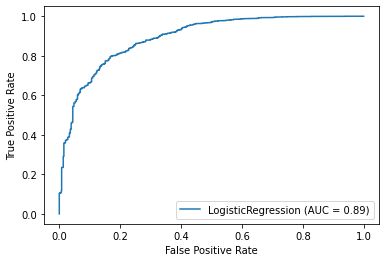

In [56]:
l = sklearn.linear_model.LogisticRegression(max_iter=500)
l.fit(xtrain,ytrain)
ypred = l.predict(xtest)
print(classification_report(ytest, ypred))
sklearn.metrics.plot_roc_curve(l, xtest, ytest)
plt.show()

              precision    recall  f1-score   support

           0       0.84      0.66      0.74      2459
           1       0.72      0.87      0.79      2459

    accuracy                           0.77      4918
   macro avg       0.78      0.77      0.76      4918
weighted avg       0.78      0.77      0.76      4918



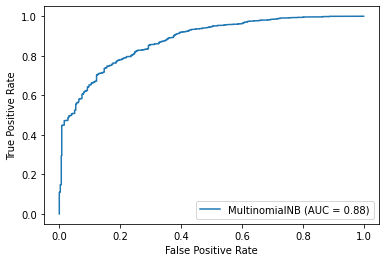

In [57]:
model = sklearn.naive_bayes.MultinomialNB()
model.fit(xtrain,ytrain)
ypred = model.predict(xtest)
print(classification_report(ytest, ypred))
sklearn.metrics.plot_roc_curve(model, xtest, ytest)
plt.show()